<br>**Task 1: Pre-done: Loading the data and preparing the data:**

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

>*Note:*
>>*In order to download the Kaggle dataset you must visit https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/
and click on the "Download" button.*

>>*If you wish to then upload the dataset to Google Colab you need to click
on "Files" on the left hand sidebar, then select "Upload" and choose the ZIP
file you downloaded from Kaggle.*


In [ ]:
# extract the dataset from the zip file that was downloaded from https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/
with zipfile.ZipFile('marketing_campaign.zip', 'r') as zip_ref:
    # Extract the contents to a folder called 'marketing_data'
    zip_ref.extractall('marketing_data')

# Note the seperator keyword here, it is because the data in the file is tab separated rather than comma seperated
# df=pd.read_csv('../input/customer-personality-analysis/marketing_campaign.csv',sep='\t')

# Updated file path to the extracted CSV file
df = pd.read_csv('/content/marketing_data/marketing_campaign.csv', sep='\t')

## The following code creates features that would be helpful to describe the profile of the customer
#  creates a new field to store the age of the customer,
#  recodes the customer's education level to numeric form (0: high-school, 1: diploma, 2: bachelors, 3: masters, and 4: doctorates)
#  recodes the customer's marital status to numeric form (0: not living with a partner, 1: living with a partner)
#  creates a new field to store the number of children in the household
#  creates a new field to store the household size

df['Age']=2022-df['Year_Birth']
df["Education"].replace({"Basic":0,"2n Cycle":1, "Graduation":2, "Master":3, "PhD":4},inplace=True)
df['Marital_Status'].replace({"Married":1, "Together":1, "Absurd":0, "Widow":0, "YOLO":0, "Divorced":0, "Single":0,"Alone":0},inplace=True)
df['Children']=df['Kidhome']+df['Teenhome']
df['Family_Size']=df['Marital_Status']+df['Children']+1

## The following code creates features that would be helpful to describe the customer's purchasing preference and behaivior
#  creates a new field to store the total spending of the customer
#  creates subsequent fields to store the spending proportion for each product by the customer

df['Total_Spending']=df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]
df['Prop_Wines']=df["MntWines"]/df["Total_Spending"]
df['Prop_Fruits']=df["MntFruits"]/df["Total_Spending"]
df['Prop_MeatProducts']=df["MntMeatProducts"]/df["Total_Spending"]
df['Prop_FishProducts']=df["MntFishProducts"]/df["Total_Spending"]
df['Prop_SweetProducts']=df["MntSweetProducts"]/df["Total_Spending"]
df['Prop_GoldProds']=df["MntGoldProds"]/df["Total_Spending"]

## The following code works out how long the customer has been with the company and store the total number of promotions the customers responded to
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'])
today=datetime.today()
df['Days_as_Customer']=(today-df['Dt_Customer']).dt.days
df['Offers_Responded_To']=df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3']+df['AcceptedCmp4']+df['AcceptedCmp5']+df['Response']

## The following code remove outliers in the dataset that are plausibly caused by data-entry errors (improbable values)
#  Generally, we would remove outliers when we do customer segmentation, as we are more interested in the general population rather than the outliers
df = df[(df["Age"]<90)]
df = df[(df["Income"]<110000)]
df = df[(df["NumWebVisitsMonth"]<11)]
df = df[(df["NumWebPurchases"]<20)]
df = df[(df["NumCatalogPurchases"]<20)]

## Finally we are going to drop some of the fields that are no longer relevant / unhelpful for the clustering
#  Note: depending on the question we would like to have answered, there is a case we can make to keep
#  'MntFruits','MntWines','MntMeatProducts','MntFishProducts','MntSweetProducts' and 'MntGoldProds', however
#  because we are interested in the purchasing preferance rather than amount spent, the field for the spending
#  proportion we created above would be more helpful
#  We dropped the responses to the individual promotions because very few customers react to those promotions
#  (not enough to form their own clusters), so instead we look at the overall response, using the field created above
#  Less than 1% of customers filed a complaint. We drop the field as it wouldn't create a meaningful cluster
fields_to_drop=['ID','Year_Birth','Dt_Customer','Z_CostContact','Z_Revenue','AcceptedCmp1',
        		'AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response','Complain',
         		'MntFruits','MntWines','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
df.drop(fields_to_drop,axis=1,inplace=True)
df.dropna(inplace=True)

## Helper function for to do 3d scatter plots,
def scatter_3d(x,y,z,c=None):
	fig = plt.figure(figsize=(10,8))
	ax = plt.subplot(111, projection='3d', label="bla")
	ax.scatter(x, y, z, s=40, c=c, marker='o',cmap=plt.cm.viridis)
	ax.set_title("The Plot Of The Clusters")
	plt.show()

<ipython-input-43-f69ec6ddb040>:38: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'])


<br> **Task 2: PCA [1 Mark]**<br>

a)
> apply StandardScaler preprocessing on the dataframe df, and assigned the
 fit_transformed values as df_scaled

In [ ]:
# apply StandardScaler preprocessing on the dataframe df, and assigned the fit_transformed values as df_scaled
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

b)
> apply PCA transformation on df_scaled using all 23 components

In [ ]:
# apply PCA transformation on df_scaled using all 23 components
pca = PCA(n_components=23)
df_transformed = pca.fit_transform(df_scaled)

c)
> plot the cummulative variance explained by the principal components.


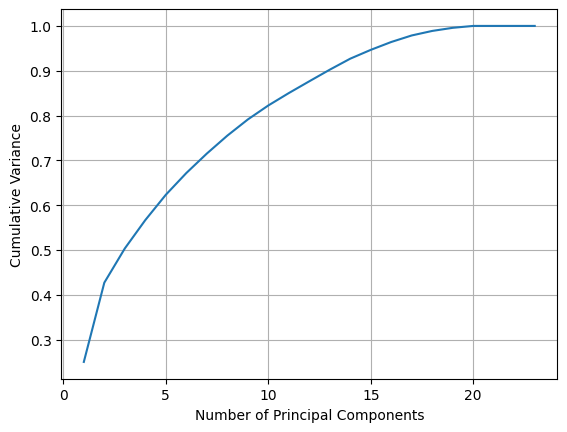



Number of components to explain at least 80% variance: 10


In [ ]:
# plot the cummulative variance explained by the principal components.
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance')
plt.grid()
plt.show()

# find the number of components explaining at least 80% variance
num_components = np.argmax(cumulative_variance_ratio >= 0.8) + 1
print(f"\n\nNumber of components to explain at least 80% variance: {num_components}")


























> How many components do you need such that at least 80% of the variance is explained?

>>**Answer:**
>>> 10

d)
> redo the PCA transformation on df_scaled using the same number of componenents as the value you worked out in 2c assigned the result of the transformation to df_transformed

In [ ]:
# redo the PCA transformation on df_scaled using the same number of componenents as the value worked out in 2c
pca = PCA(n_components=num_components)

# assign the result of the transformation to df_transformed
df_transformed = pca.fit_transform(df_scaled)

e)
> visualize the first 3 components of df_transformed using a 3d scatter plot, (Hint: you may use the helper function scatter_3d)

<ipython-input-43-f69ec6ddb040>:69: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, z, s=40, c=c, marker='o',cmap=plt.cm.viridis)


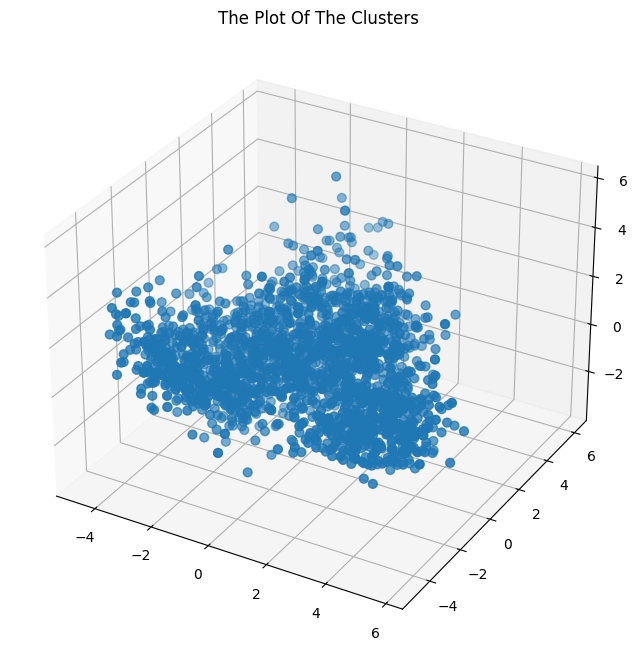

In [ ]:
# visualize the first 3 components of df_transformed using a 3d scatter plot with the helper function scatter_3d
scatter_3d(df_transformed[:, 0], df_transformed[:, 1], df_transformed[:, 2])







<br>**Task 3: KMeans Clustering [1 Mark]**<br>

a)
> Apply KMeans clustering to df_transformed and measure the inertia score for n_clusters between 2 and 10

In [ ]:
# for storing inertia scores
inertia_scores = []

# apply KMeans clustering to df_transformed and measure the inertia score for n_clusters between 2 and 10
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_transformed)
    inertia_scores.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

b)
> plot the inertia score.

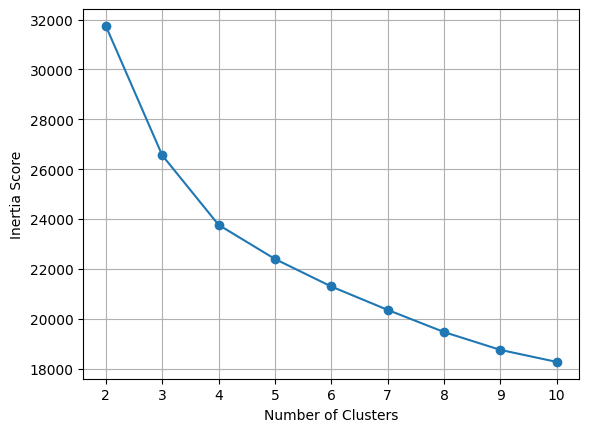

In [ ]:



# plot the inertia scores
plt.plot(range(2, 11), inertia_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia Score')
plt.grid(True)
plt.show()



>What would you say is the best number of clusters for this dataset? Why?
>> **Answer:**
>>> The best number of clusters for this dataset is 4 because it's where the curve starts to show a notably slower decrease in inertia. This suggests that adding more clusters beyond this point doesn't significantly reduce the inertia.

c)
> Find the cluster labels of KMeans(n_clusters=4) on df_transformed, (It doesn't matter what your answer for 3b is, set n_clusters=4)

In [ ]:
# for all random steps (i.e. KMeans), specify a random seed! Always use your student id as the random seed.
MY_ID = 1481257

# it doesn't matter what your answer for 3b is, set n_clusters=4
kmeans = KMeans(n_clusters=4, random_state = MY_ID)

# find the cluster labels of KMeans(n_clusters=4) on df_transformed
cluster_labels = kmeans.fit_predict(df_transformed)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


d)
> Assign the cluster labels as df['Clusters']

In [ ]:
# assign the cluster labels as df['Clusters']
df['Clusters'] = cluster_labels

e)
> visualize the first 3 components of df_transformed using a 3d scatter plot, with the data points coloured according to the clusters

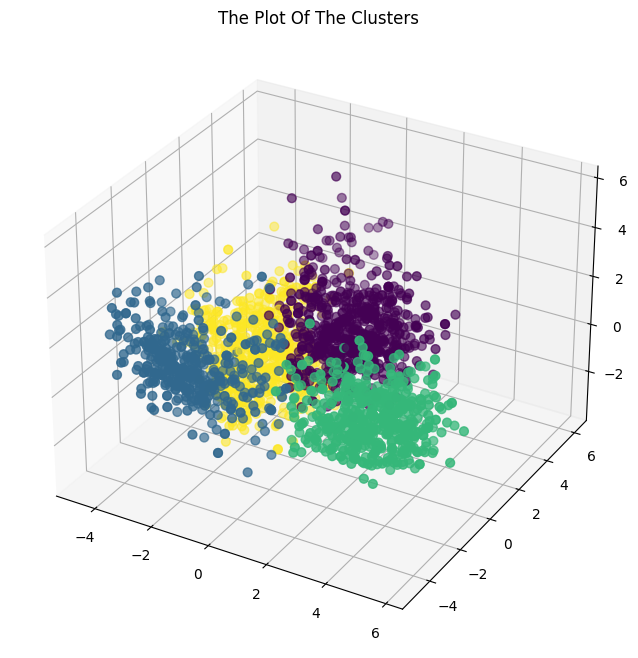

In [ ]:
# visualize the first 3 components of df_transformed using a 3d scatter plot, with the data points coloured according to the clusters
scatter_3d(df_transformed[:, 0], df_transformed[:, 1], df_transformed[:, 2], c=df['Clusters'])


**Task 4: Interpretating our results [1 Mark]**

a)
> Do a scatter plot between df['Income'] and df['Total_spending'] and colour the data points according the clusters.

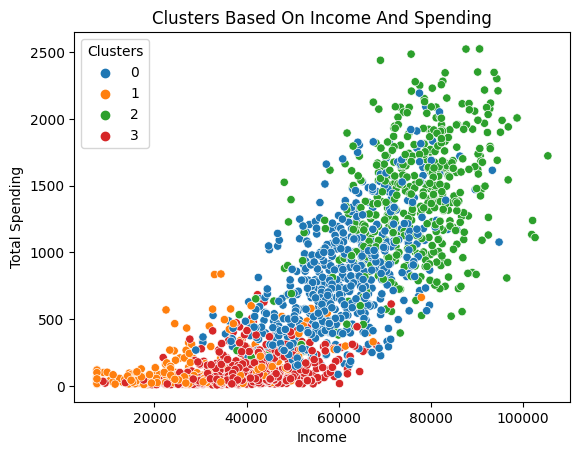

In [ ]:
# prepare to colour the data points according to the clusters
cluster_palette = sns.color_palette("tab10", 4)

# Do a scatter plot between df['Income'] and df['Total_spending'] and colour the data points according the clusters
pl = sns.scatterplot(data=df, x="Income", y="Total_Spending", hue="Clusters", palette=cluster_palette)

plt.xlabel('Income')
plt.ylabel('Total Spending')
plt.title("Clusters Based On Income And Spending")
plt.show()

b)
> Do a boxplot by clusters, for each of these following fields describing the attributes of the customer<br>
```
['Age'.'Education','Marital_Status','Income', 'Children', 'Family_Size','Kidhome','Teenhome']
```



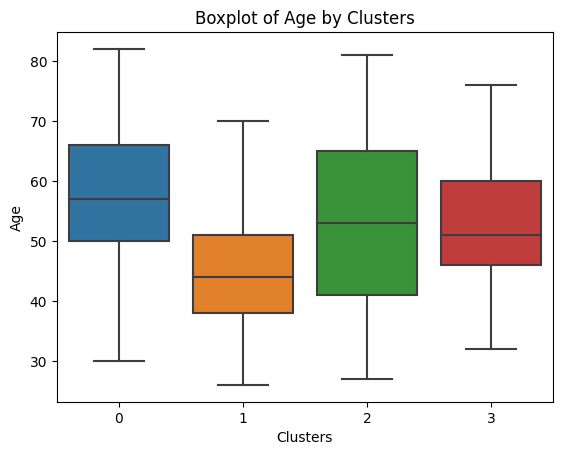

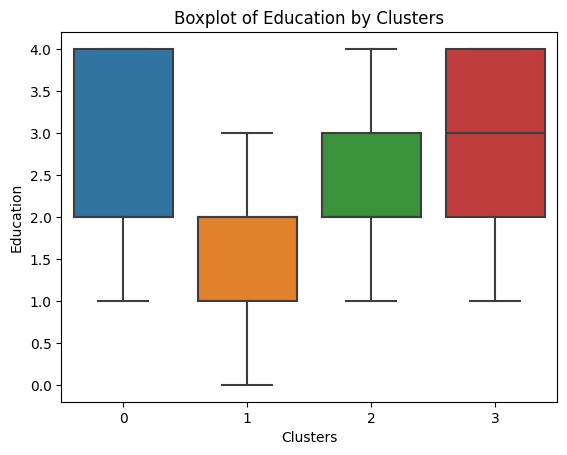

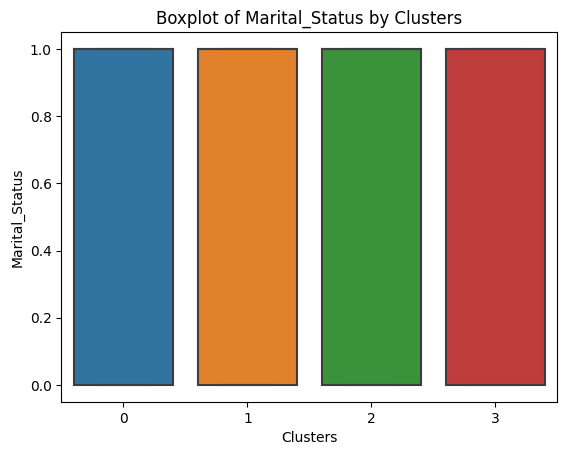

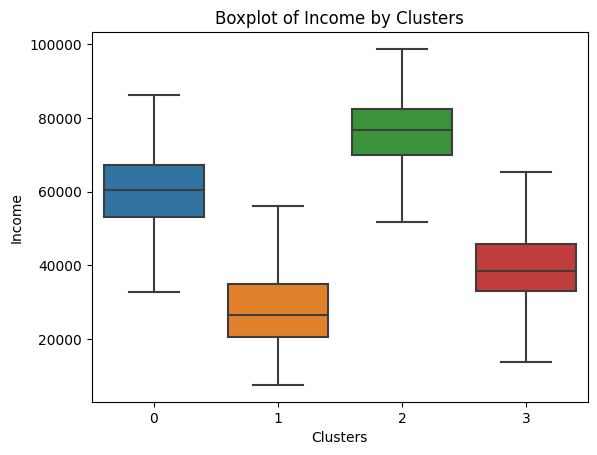

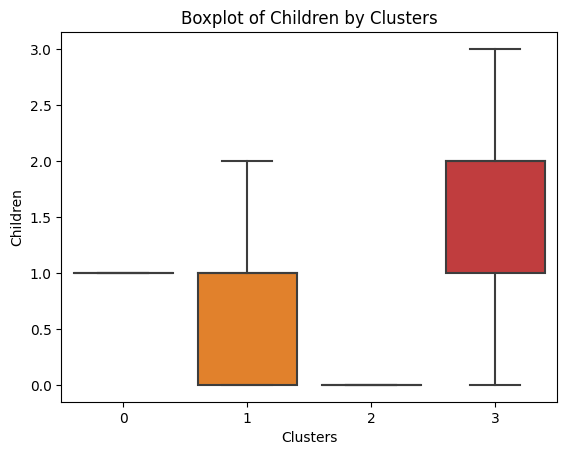

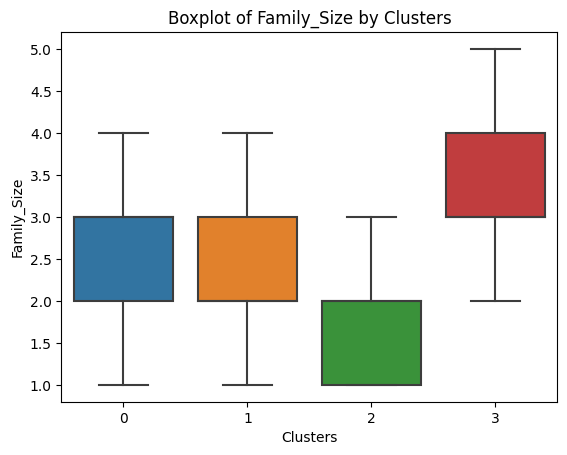

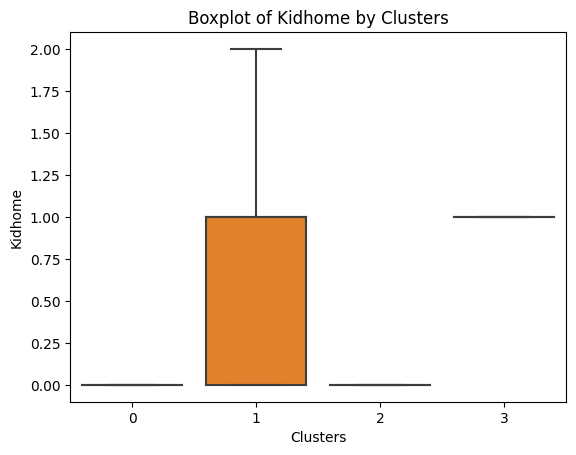

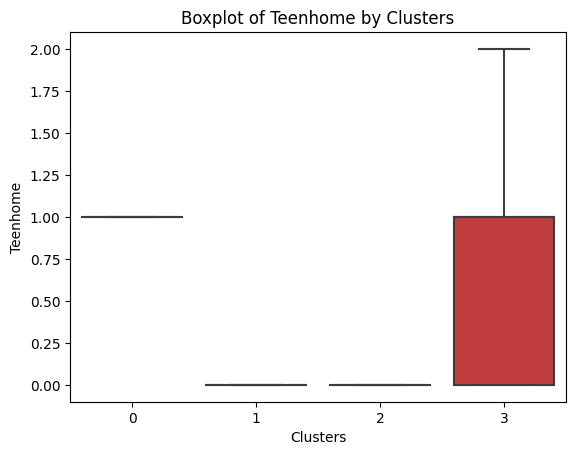

In [ ]:
# customer attributes
attributes = ['Age', 'Education', 'Marital_Status', 'Income', 'Children', 'Family_Size', 'Kidhome', 'Teenhome']

# do Boxplots by clusters for customer attributes
for attr in attributes:
    sns.boxplot(data=df, x='Clusters', y=attr, showfliers=False)
    plt.title(f'Boxplot of {attr} by Clusters')
    plt.show()



c)
> Do a boxplot by clusters, for each of these following fields describing the customer preference<br>
```
['Total_Spending','Prop_Wines','Prop_Fruits','Prop_MeatProducts','Prop_FishProducts','Prop_SweetProducts','Prop_GoldProds']
```


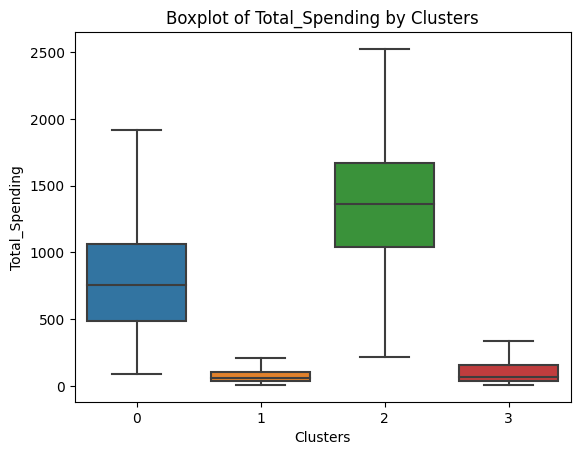

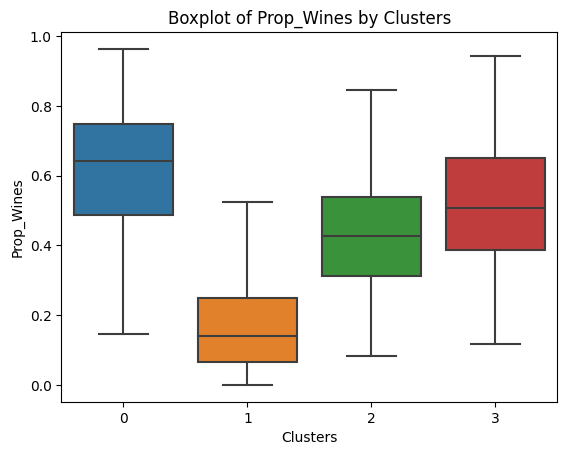

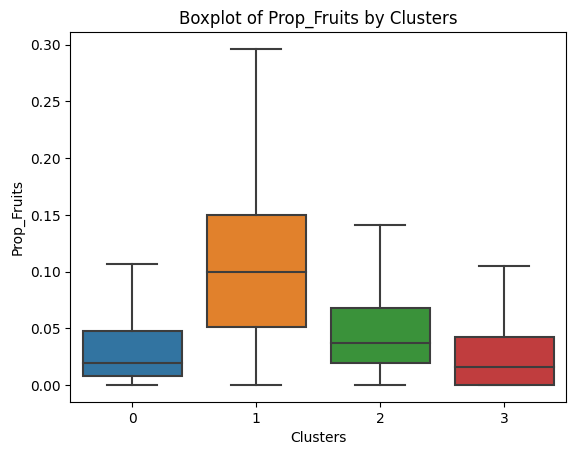

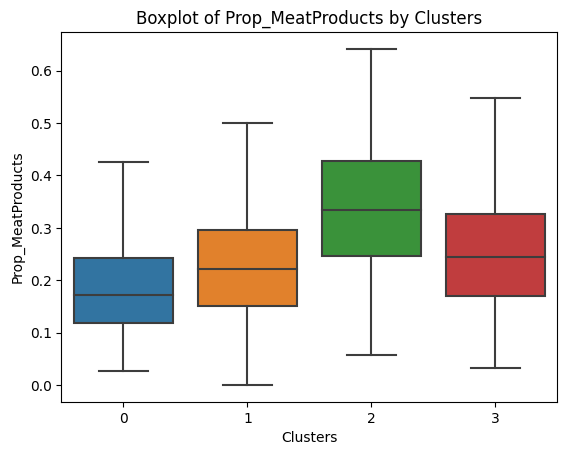

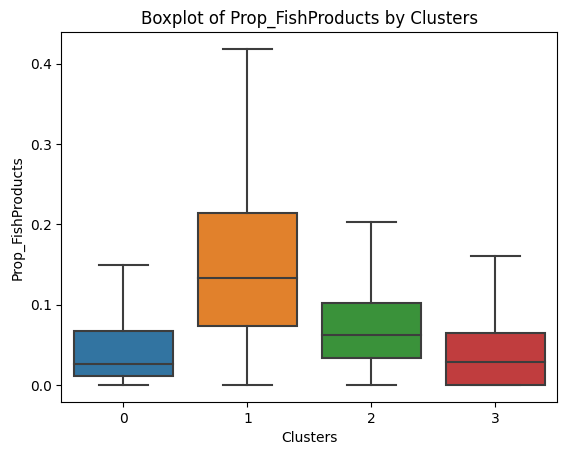

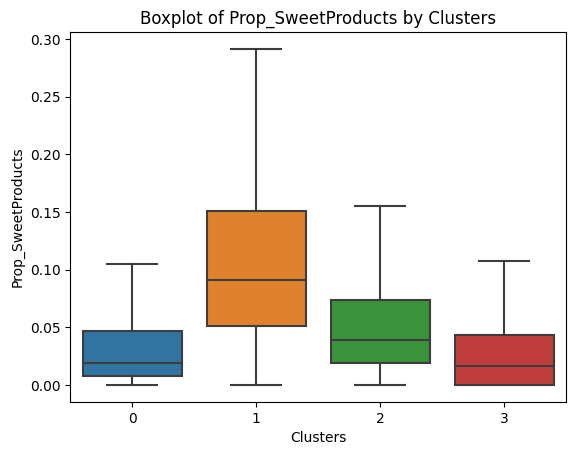

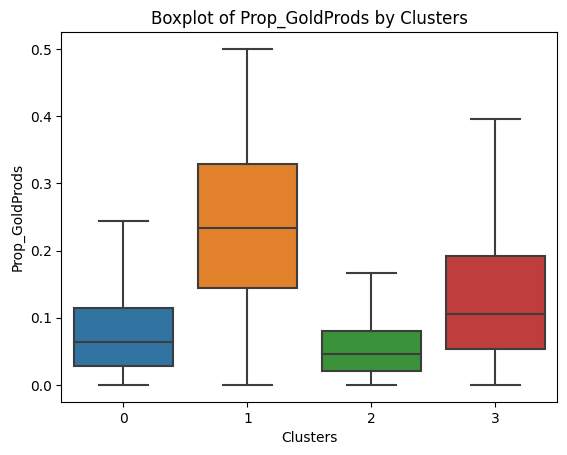

In [ ]:
# customer preferences
preferences = ['Total_Spending', 'Prop_Wines', 'Prop_Fruits', 'Prop_MeatProducts', 'Prop_FishProducts', 'Prop_SweetProducts', 'Prop_GoldProds']

# do Boxplots by clusters for customer preferences
for pref in preferences:
    sns.boxplot(data=df, x='Clusters', y=pref, showfliers=False)
    plt.title(f'Boxplot of {pref} by Clusters')
    plt.show()






d)
> Do a boxplot by clusters, for each of these following fields describing the customer behaivoir<br>
```
['Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
'Days_as_Customer', 'Offers_Responded_To']
```
	   

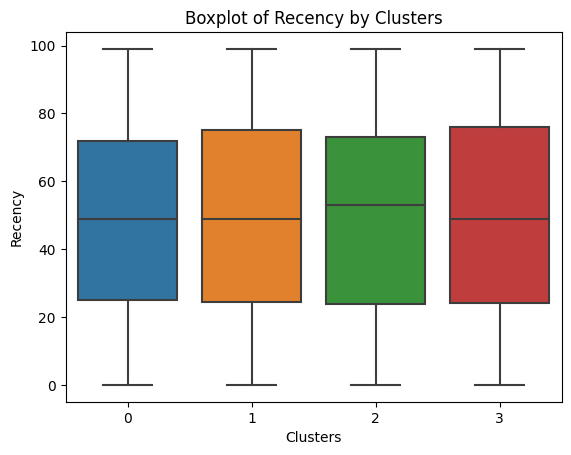

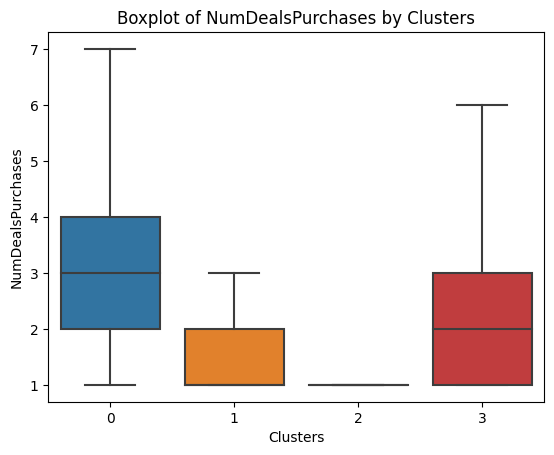

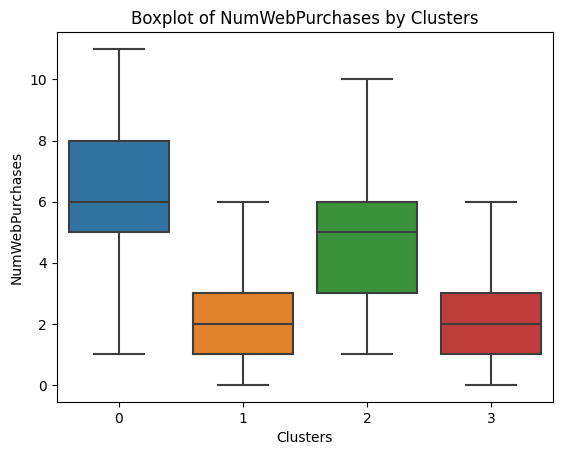

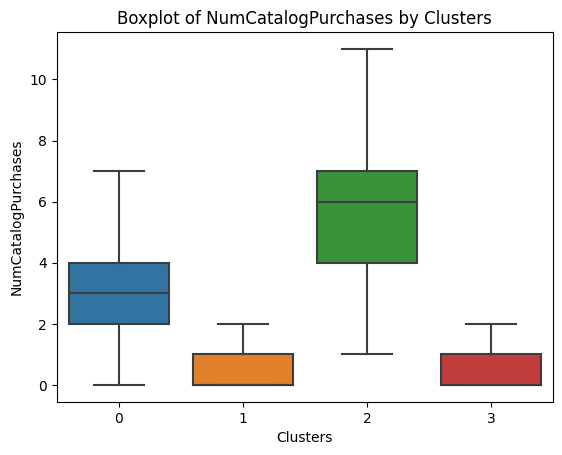

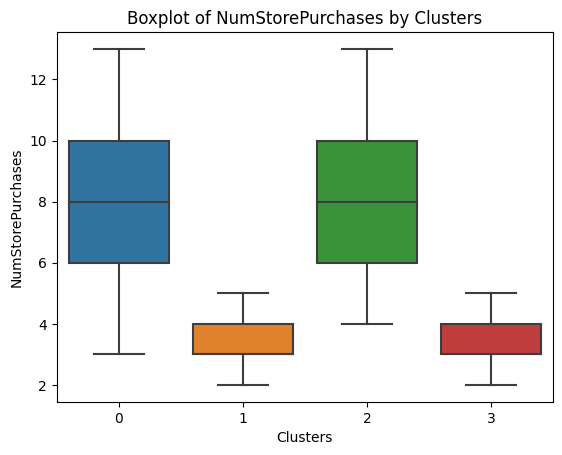

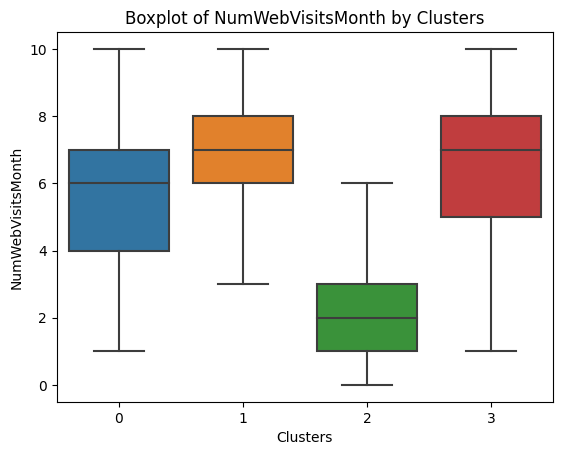

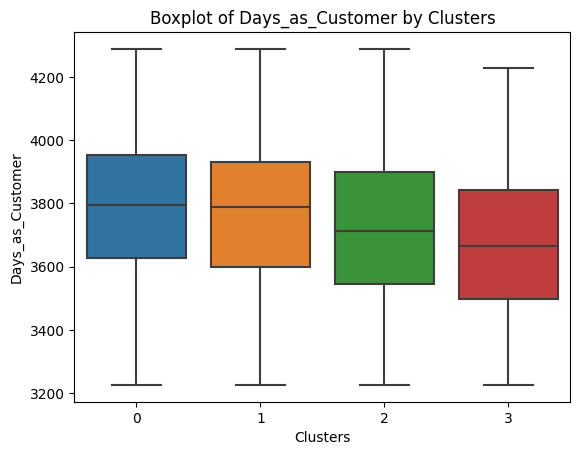

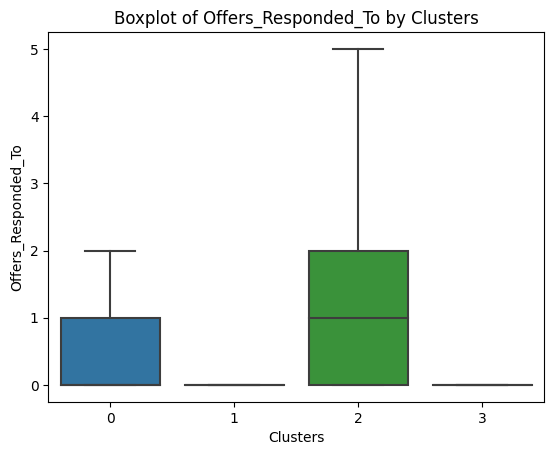

In [ ]:
# customer behaviour
behavior = ['Recency', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
            'NumStorePurchases', 'NumWebVisitsMonth', 'Days_as_Customer', 'Offers_Responded_To']

# do Boxplots by clusters for customer behaviour
for behav in behavior:
    sns.boxplot(data=df, x='Clusters', y=behav, showfliers=False)
    plt.title(f'Boxplot of {behav} by Clusters')
    plt.show()

e)
> Obtain the means grouped by the cluster, for each of the fields. (See hints for a 1-liner code)

In [ ]:
# obtain the means grouped by the cluster for all fields
means_by_cluster = df.groupby('Clusters').mean().T

# display the results
print(means_by_cluster)


Clusters                        0             1             2             3
Education                2.665109      1.653012      2.505859      2.733547
Marital_Status           0.674455      0.624096      0.587891      0.678973
Income               60193.596573  28427.727711  75882.820312  39098.995185
Kidhome                  0.163551      0.665060      0.023438      0.927769
Teenhome                 0.967290      0.096386      0.044922      0.683788
Recency                 48.498442     48.922892     49.445312     49.401284
NumDealsPurchases        3.484424      1.804819      1.046875      2.454254
NumWebPurchases          6.345794      2.166265      4.896484      2.382022
NumCatalogPurchases      3.344237      0.604819      5.912109      0.606742
NumStorePurchases        7.968847      3.296386      8.279297      3.394864
NumWebVisitsMonth        5.549844      6.522892      2.640625      6.399679
Age                     57.838006     45.768675     53.341797     52.873194
Children    

>*Note:*
>>*It was stated in the instructions that there would be discussion questions for task 4, but I could'nt find any so instead I'll discuss my observations.*
<br>

>**Discussion:**
>> Customers in Cluster 0 have a high average education level (approximately 2.665),which is second only to cluster 3, and as such the cluster represents well-educated people.<br><br>
This cluster is also beaten by cluster 3 in terms of number of people who are married, and in average family size, but not in terms of average income.
<br>
So, when compared to cluster 0, cluster 3 has more customers who are married and have bigger families, but these people also have a smaller income on average.
<br><br>
Cluster 0 has the highest average number of web purchases and deal purchases, and it contains customers that have, on average, been customers for longer than people in other clusters.<br><br>
The average age in cluster 0 is the highest of all 4 (around 57.838). These customers may be older, potentially primarily representing later life families that mostly consist of adults.<br><br>
Cluster 0 exhibits the second highest average total spending, only overhsadowed by cluster 2. Though, it should be noted that cluster 2 responds to offers much more often that than any other cluster so it may be possible that the high average spending noted with them has more to do with reacting to offers than it does with ensuring that their shopping needs are met.

>>Cluster 1 has the lowest average education level (around 1.65), and it's average income is also the lowest among the clusters (approximately $28,427.73).
Customers in Cluster 1 have the lowest average total spending, providing further indication that this cluster of people may have limited purchasing power.
